# Shelter Animal Outcomes

**Дано:** данные о кошках и собаках, поступивших в приют

**Найти:** что с ними станет? Возьмут в приют / вернётся хозяин / ...

In [111]:
import numpy as np
import pandas as pd

In [112]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")

#### Загружаем датасет

In [113]:
data = pd.read_csv('Shelter.csv')

и смотрим на это

In [114]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [115]:
from sklearn.preprocessing import LabelEncoder

In [116]:
le = LabelEncoder()
y = le.fit_transform(data.OutcomeType)

## все фичи надо обрабатывать

In [117]:
X = data.drop(['AnimalID', 'OutcomeType'], axis=1)
X.index = range(len(X))
X.columns = X.columns.str.lower()
data_columns = X.columns

In [118]:
X['breed'].unique()

array(['Shetland Sheepdog Mix', 'Domestic Shorthair Mix', 'Pit Bull Mix',
       ..., 'Vizsla/Boxer', 'German Shepherd/Australian Kelpie',
       'Boxer/German Shepherd'], dtype=object)

In [119]:
X['datetime']= pd.to_datetime(X['datetime'])

In [120]:
X.head()

,name,datetime,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,Hambone,2014-02-12 18:22:00,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [121]:
X.shape

(26729, 8)

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            19038 non-null  object        
 1   datetime        26729 non-null  datetime64[ns]
 2   outcomesubtype  13117 non-null  object        
 3   animaltype      26729 non-null  object        
 4   sexuponoutcome  26728 non-null  object        
 5   ageuponoutcome  26711 non-null  object        
 6   breed           26729 non-null  object        
 7   color           26729 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.6+ MB


Также нам необходимо закодировать значения целевой переменной

In [123]:
from sklearn.preprocessing import LabelEncoder

In [124]:
le = LabelEncoder()
y = le.fit_transform(data.OutcomeType)

In [125]:
y

array([3, 2, 0, ..., 0, 4, 4])

# Готовим фичи

будем в конце датафрейма наращивать числовые фичи, не удаляя оригинальные: вдруг пригодится :))

**имя** превращаем в:
* наличие имени
* длину имени
* частоту имени

#### Даты: переводим строки в даты

In [126]:
X.sexuponoutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [127]:
names = X[['name']].value_counts(normalize = True)

In [128]:
def convert_age(x):
    if pd.isnull(x):
        return 0
    else:
        t = x.split()
        if (t[1][0] == 'y'):
            return int(t[0]) * 365
        elif (t[1][0] == 'w'):    
            return int(t[0]) * 7
        else:
            return int(t[0])

X['hasname'] = X['name'].transform(lambda x: 0 if pd.isnull(x) else 1)
X['namefreq'] = X['name'].transform(lambda x: 0.0 if pd.isnull(x) else names[x][0])
X['dog'] = X['animaltype'].transform(lambda x: 0 if x == 'Cat' else 1)
X['age'] = X['ageuponoutcome'].transform(convert_age)
X['male'] = X['sexuponoutcome'].transform(lambda x: 1 if ((not pd.isnull(x)) and ('Male' in x)) else 0)
X['female'] = X['sexuponoutcome'].transform(lambda x: 1 if ((not pd.isnull(x)) and ('Female' in x)) else 0)
X['intact'] = X['sexuponoutcome'].transform(lambda x: 1 if ((not pd.isnull(x)) and ('Intact' in x)) else 0)
X['fixed'] = X['sexuponoutcome'].transform(lambda x: 1 if ((not pd.isnull(x)) and (not 'Intact' in x)) else 0)
X['mix'] = X['breed'].transform(lambda x: 1 if ((not pd.isnull(x)) and 'Mix' in x) else 0)
X['domestic'] = X['breed'].transform(lambda x: 1 if ((not pd.isnull(x)) and 'Domestic' in x) else 0)
X['year'] = X['datetime'].transform(lambda x: x.year)
X['month'] = X['datetime'].transform(lambda x: x.month)
X['suffering'] = X['outcomesubtype'].transform(lambda x: 1 if x == 'Suffering' else 0)

In [129]:
X

,name,datetime,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color,hasname,namefreq,...,age,male,female,intact,fixed,mix,domestic,year,month,suffering
0,Hambone,2014-02-12 18:22:00,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,0.000263,...,365,1,0,0,1,1,0,2014,2,0
1,Emily,2013-10-13 12:44:00,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,0.000840,...,365,0,1,0,1,1,1,2013,10,1
2,Pearce,2015-01-31 12:28:00,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,0.000105,...,730,1,0,0,1,1,0,2015,1,0
3,NaN,2014-07-11 19:09:00,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,0.000000,...,21,1,0,1,0,1,1,2014,7,0
4,NaN,2013-11-15 12:52:00,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,0.000000,...,730,1,0,0,1,0,0,2013,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,NaN,2015-05-14 11:56:00,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,0,0.000000,...,1,1,0,1,0,1,1,2015,5,0
26725,NaN,2016-01-20 18:59:00,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,0,0.000000,...,3,0,1,0,1,1,1,2016,1,0
26726,Zeus,2015-03-09 13:33:00,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,1,0.001891,...,1460,1,0,0,1,1,0,2015,3,0
26727,NaN,2014-04-27 12:22:00,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,0,0.000000,...,28,1,0,1,0,1,1,2014,4,0


In [130]:
X = X.drop(['name', 'datetime', 'animaltype', 'sexuponoutcome', 'ageuponoutcome', 'breed', 'color', 'year', 'month', 'outcomesubtype'], axis=1)
X

,hasname,namefreq,dog,age,male,female,intact,fixed,mix,domestic,suffering
0,1,0.000263,1,365,1,0,0,1,1,0,0
1,1,0.000840,0,365,0,1,0,1,1,1,1
2,1,0.000105,1,730,1,0,0,1,1,0,0
3,0,0.000000,0,21,1,0,1,0,1,1,0
4,0,0.000000,1,730,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
26724,0,0.000000,0,1,1,0,1,0,1,1,0
26725,0,0.000000,0,3,0,1,0,1,1,1,0
26726,1,0.001891,1,1460,1,0,0,1,1,0,0
26727,0,0.000000,0,28,1,0,1,0,1,1,0


#### Осталось проверить итоговую таблицу на пропуски

In [131]:
X.isnull().sum()

hasname      0
namefreq     0
dog          0
age          0
male         0
female       0
intact       0
fixed        0
mix          0
domestic     0
suffering    0
dtype: int64

In [132]:
X.shape

(26729, 11)

In [133]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [134]:
X_sdt = scaler.transform(X)
X_sdt = pd.DataFrame(X_sdt, columns=X.columns)
X_sdt

,hasname,namefreq,dog,age,male,female,intact,fixed,mix,domestic,suffering
0,0.635595,-0.305173,0.844954,-0.351970,1.004537,-0.925440,-0.597733,0.597790,0.445777,-0.798188,-0.197351
1,0.635595,0.190562,-1.183497,-0.351970,-0.995483,1.080568,-0.597733,0.597790,0.445777,1.252838,5.067114
2,0.635595,-0.440373,0.844954,-0.022272,1.004537,-0.925440,-0.597733,0.597790,0.445777,-0.798188,-0.197351
3,-1.573328,-0.530507,-1.183497,-0.662699,1.004537,-0.925440,1.672989,-1.672827,0.445777,1.252838,-0.197351
4,-1.573328,-0.530507,0.844954,-0.022272,1.004537,-0.925440,-0.597733,0.597790,-2.243273,-0.798188,-0.197351
...,...,...,...,...,...,...,...,...,...,...,...
26724,-1.573328,-0.530507,-1.183497,-0.680765,1.004537,-0.925440,1.672989,-1.672827,0.445777,1.252838,-0.197351
26725,-1.573328,-0.530507,-1.183497,-0.678958,-0.995483,1.080568,-0.597733,0.597790,0.445777,1.252838,-0.197351
26726,0.635595,1.091899,0.844954,0.637124,1.004537,-0.925440,-0.597733,0.597790,0.445777,-0.798188,-0.197351
26727,-1.573328,-0.530507,-1.183497,-0.656376,1.004537,-0.925440,1.672989,-1.672827,0.445777,1.252838,-0.197351


In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sdt, y, test_size=0.2, random_state=42)

In [136]:
X_train.shape

(21383, 11)

In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
clf = DecisionTreeClassifier(max_depth=7)

In [139]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [140]:
from sklearn.metrics import classification_report

In [141]:
report = classification_report(y_test, clf.predict(X_test), target_names=data['OutcomeType'].unique())
print(report)

                 precision    recall  f1-score   support

Return_to_owner       0.67      0.81      0.73      2219
     Euthanasia       0.00      0.00      0.00        33
       Adoption       0.98      0.64      0.77       298
       Transfer       0.46      0.42      0.44       961
           Died       0.76      0.66      0.71      1835

       accuracy                           0.67      5346
      macro avg       0.57      0.50      0.53      5346
   weighted avg       0.68      0.67      0.67      5346



In [142]:
from sklearn.model_selection import GridSearchCV
depths = np.arange(1, 20)
grid = {
    'max_depth': depths
}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, cv=5, n_jobs=-1, verbose=1)
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    3.1s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             verbose=1)

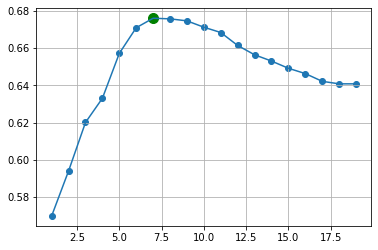

In [143]:
# визуализация поиска лучшего параметра max_depth 
scores = [x.mean() for x in gridsearch.cv_results_['mean_test_score']]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmax(scores)
plt.grid()
plt.scatter(depths[best_point], scores[best_point], c='g', s=100);

In [144]:
grid = {
    'max_depth': depths,
    'criterion': ['gini', 'enthropy'],
    'splitter': ['best', 'random']
}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, cv=5, n_jobs=-1, verbose=1)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed:    2.2s finished


{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}

In [145]:
from sklearn.metrics import classification_report
report = classification_report(y_test, gridsearch.predict(X_test), target_names=data.OutcomeType.unique())
print(report)

                 precision    recall  f1-score   support

Return_to_owner       0.67      0.81      0.73      2219
     Euthanasia       0.00      0.00      0.00        33
       Adoption       0.98      0.64      0.77       298
       Transfer       0.46      0.42      0.44       961
           Died       0.76      0.66      0.71      1835

       accuracy                           0.67      5346
      macro avg       0.57      0.50      0.53      5346
   weighted avg       0.68      0.67      0.67      5346



Визуализация дерева

In [146]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

http://www.webgraphviz.com

In [147]:
#get_tree_dot_view(clf, list(Xtrain_prep.columns), list(le.classes_))

In [148]:
y_pred_proba = gridsearch.predict_proba(X_test)
y_pred = gridsearch.predict(X_test)

In [149]:
y_pred

array([3, 0, 4, ..., 0, 4, 3])

In [150]:
from sklearn.preprocessing import label_binarize
n_classes = len(set(y_test))
y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
y_test_bin

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [151]:
precision = dict()
recall = dict()

In [152]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [153]:
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                       y_pred_proba[:,i])

In [154]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.839750155623246

### ЗАДАНИЕ 2

1. Построить модель логистической регрессии с наилучшим качеством.

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [156]:
#scaler = StandardScaler()
#X['namefreq'] = scaler.fit_transform(X['namefreq'])

In [171]:
model = LogisticRegression(C=1, penalty='l1', solver='saga', tol=0.001).fit(X_train, y_train)

In [172]:
y_pred = model.predict(X_test)
y_pred_broba = model.predict_proba(X_test)

In [173]:
accuracy_score(y_test, y_pred)

0.6683501683501684

In [174]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.839750155623246

In [164]:
grid = {'C': [0.01, 0.1, 1], 
       'penalty':['l1', 'l2'],
       'tol':[0.001, 0.0001, 0.00001],
       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
gridsearch = GridSearchCV(LogisticRegression(), grid, cv=5, n_jobs=-1, verbose=1)

In [165]:
%%time
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.0min finished


Wall time: 2min 1s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.001, 0.0001, 1e-05]},
             verbose=1)

In [166]:
gridsearch.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}

### Также [можно](http://scikit-learn.org/stable/modules/model_persistence.html) сохранять и модели:


In [161]:
import joblib

In [163]:
#joblib.dump(clf, 'data/shelter/clf_decisiontree_maxdepth_9.pkl')